<a href="https://colab.research.google.com/github/JMindpalace/Project_4-Deep-learning-/blob/main/Tree%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 Import

In [ ]:
!pip install pydot

In [ ]:
!pip install graphviz

In [111]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # 데이터 전처리
from tensorflow.keras.preprocessing import image_dataset_from_directory # 자동 라벨링

In [112]:
from keras.applications.nasnet import NASNetLarge, NASNetMobile # 사전 훈련 모델

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.applications.vgg16 import VGG16

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

# 데이터 Read

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [115]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2,
        # 추가 전처리(데이터 증식 효과)
        rotation_range=5,       # 무작위 5도 이내 회전
        width_shift_range=0.2,  # 수평 평행이동
        height_shift_range=0.2, # 수직 평행이동
        shear_range=0.2,        # 이미지 기울기
        horizontal_flip=True,   # 가로 반전
        vertical_flip=True,     # 세로 반전
        fill_mode='nearest')    # 빈 공간을 채울 방법

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen  = ImageDataGenerator(rescale = 1./255 )

# 자동 라벨링 방식 채택 - target_size는 일단 128*128(크기가 크면 특징을 잘 찾지만 느려짐)
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/new/train',
                                                   target_size = (331,331), class_mode = 'categorical', subset = 'training', batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/new/train',
                                                  target_size = (331,331), class_mode = 'categorical', subset = 'validation', batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/new/test',
                                                  target_size = (331,331), class_mode = 'categorical', batch_size = 64)

Found 160 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


# CNN Model 1 - 4 Classfication Ah(label)

In [116]:
# ResNet50, mobilenet.MobileNet, VGG16, NASNetLarge
base_model = tf.keras.applications.ResNet50(input_shape=(331,331,3), include_top=False, weights="imagenet")
for layer in base_model.layers: # 학습률 고정
    layer.trainable=False

In [117]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding='same' ))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

In [118]:
METRICS = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), # threshold=0.5 , metrics = ['accuracy']는 threshold가 다름(y_pred and y_true)
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),  
           tf.keras.metrics.AUC(name='auc'), ]

In [119]:
lrd = ReduceLROnPlateau( monitor = 'val_loss', patience = 20, verbose = 1, factor = 0.50 )
es = EarlyStopping(verbose=1, patience=20)

In [125]:
%%time
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = METRICS ) # ['accuracy']

# 그래프를 위해 변수 변경
nasnetlarge_data = model.fit( train_dataset, validation_data=valid_dataset, epochs = 20, verbose = 1, callbacks=[lrd, es] )

Epoch 1/20
3/3 [==============================] - 64s 24s/step - loss: 1.5538 - accuracy: 0.6611 - precision: 0.2576 - recall: 0.1889 - auc: 0.5191 - val_loss: 3.2804 - val_accuracy: 0.6250 - val_precision: 0.2500 - val_recall: 0.2500 - val_auc: 0.4811 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 55s 22s/step - loss: 1.5217 - accuracy: 0.7172 - precision: 0.3521 - recall: 0.1562 - auc: 0.5711 - val_loss: 4.5193 - val_accuracy: 0.6250 - val_precision: 0.2500 - val_recall: 0.2500 - val_auc: 0.5190 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 57s 19s/step - loss: 1.5841 - accuracy: 0.7172 - precision: 0.3478 - recall: 0.1500 - auc: 0.5476 - val_loss: 5.9703 - val_accuracy: 0.6250 - val_precision: 0.2500 - val_recall: 0.2500 - val_auc: 0.5074 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 55s 22s/step - loss: 1.6305 - accuracy: 0.6953 - precision: 0.2388 - recall: 0.1000 - auc: 0.5186 - val_loss: 7.1146 - val_accuracy: 0.6250 - val_precis

In [126]:
model.evaluate(test_dataset, verbose=2)

4/4 - 53s - loss: 4.5662 - accuracy: 0.6250 - precision: 0.2500 - recall: 0.2500 - auc: 0.5067 - 53s/epoch - 13s/step


[4.566224098205566, 0.625, 0.25, 0.25, 0.5066750049591064]

In [127]:
nasnetlarge_loss = nasnetlarge_data.history['loss']

nasnetlarge_acc = nasnetlarge_data.history['accuracy']

nasnetlarge_val_acc = nasnetlarge_data.history['val_accuracy']

nasnetlarge_val_loss = nasnetlarge_data.history['val_loss']

nasnetlarge_data = pd.DataFrame(zip(nasnetlarge_loss, nasnetlarge_acc, nasnetlarge_val_loss, nasnetlarge_val_acc) , columns = (['loss', 'acc', 'val_loss', 'val_acc']) )
nasnetlarge_data

,loss,acc,val_loss,val_acc
0,1.553827,0.661111,3.280448,0.625
1,1.521745,0.717188,4.519321,0.625
2,1.584128,0.717188,5.970303,0.625
3,1.630456,0.695312,7.114592,0.625
4,1.628573,0.695312,5.424916,0.625
5,1.568544,0.723437,3.592895,0.625
6,1.511368,0.721875,2.986611,0.625
7,1.476810,0.734375,4.319725,0.625
8,1.483363,0.715625,5.564985,0.625
9,1.474897,0.726562,5.401791,0.625


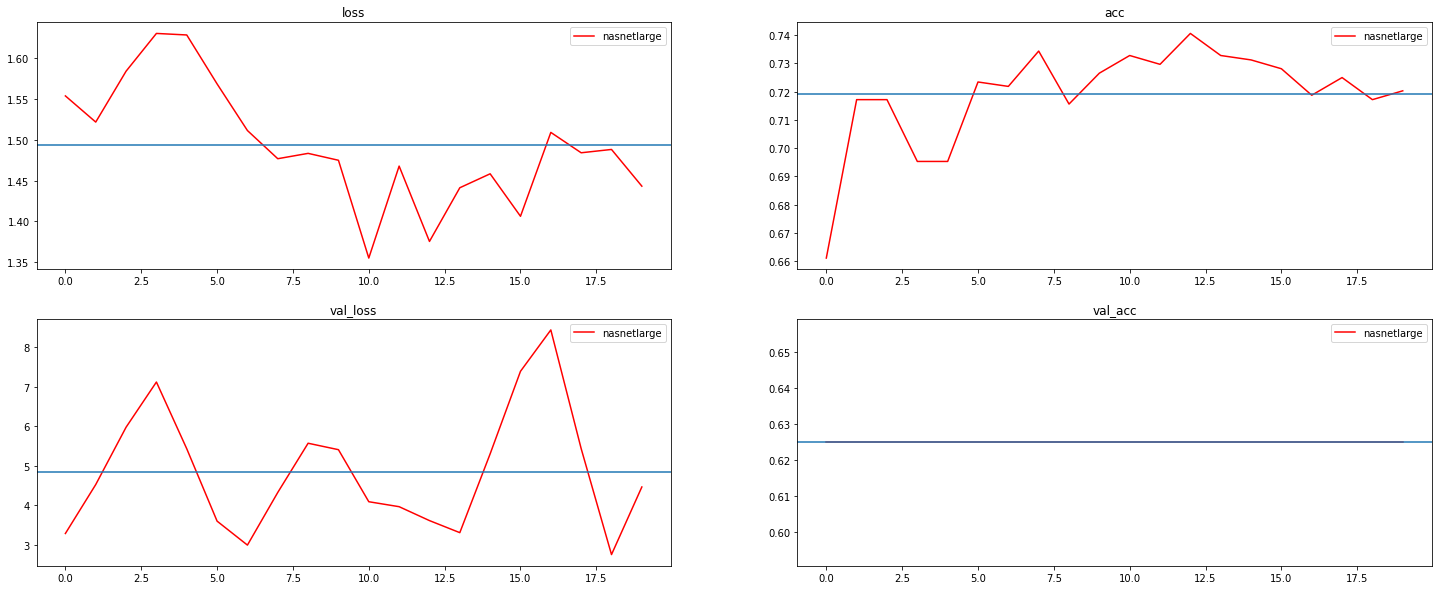

In [134]:
# val_acc 고정 이유 찾기

plt.figure(figsize=(25, 10))
for i in range(0, 4):
  plt.subplot( 2, 2, i+1 )
  plt.plot( nasnetlarge_data.iloc[:,[i]] , 'r' , label='nasnetlarge' )
  plt.axhline(y=np.nanmean(nasnetlarge_data.iloc[:,[i]]))
  plt.title( nasnetlarge_data.columns[i] )
  plt.legend()
plt.show();

## 그래프 재료(사전학습모델 비교값들)

In [ ]:
resnet50_loss = resnet50_data_acc.history['loss']

resnet50_acc = resnet50_data_acc.history['accuracy']

resnet50_val_acc = resnet50_data_acc.history['val_accuracy']

resnet50_val_loss = resnet50_data_acc.history['val_loss']

resnet_data_acc = pd.DataFrame(zip(resnet50_loss, resnet50_acc, resnet50_val_loss, resnet50_val_acc) , columns = (['loss', 'acc', 'val_loss', 'val_acc']) )
resnet_data_acc

,loss,acc,val_loss,val_acc
0,1.716382,0.704241,3.625596,0.62500
1,1.713721,0.684375,3.208466,0.62500
2,1.720112,0.698438,2.768537,0.62500
3,1.563906,0.718750,2.453012,0.62500
4,1.599157,0.710938,2.165803,0.63125


In [ ]:
mobilenet_loss = mobilenet_data.history['loss']

mobilenet_acc = mobilenet_data.history['accuracy']

mobilenet_val_acc = mobilenet_data.history['val_accuracy']

mobilenet_val_loss = mobilenet_data.history['val_loss']

mobilenet_data = pd.DataFrame(zip(mobilenet_loss, mobilenet_acc, mobilenet_val_loss, mobilenet_val_acc) , columns = (['loss', 'acc', 'val_loss', 'val_acc']) )
mobilenet_data

,loss,acc,val_loss,val_acc
0,1.880895,0.670313,27.407307,0.625
1,1.742358,0.693750,33.657772,0.625
2,1.667068,0.709375,33.531219,0.625
3,1.663031,0.709375,30.041952,0.625
4,1.612234,0.706250,26.463161,0.625


In [ ]:
vgg16_loss = vgg16_data.history['loss']

vgg16_acc = vgg16_data.history['accuracy']

vgg16_val_acc = vgg16_data.history['val_accuracy']

vgg16_val_loss = vgg16_data.history['val_loss']

vgg16_data = pd.DataFrame(zip(vgg16_loss, vgg16_acc, vgg16_val_loss, vgg16_val_acc) , columns = (['loss', 'acc', 'val_loss', 'val_acc']) )
vgg16_data

,loss,acc,val_loss,val_acc
0,1.657794,0.698438,2.277634,0.62500
1,1.709765,0.707812,1.863204,0.65625
2,1.635087,0.703125,6.841353,0.63750
3,1.621766,0.723437,11.189189,0.62500
4,1.634716,0.707812,11.407051,0.63750


In [ ]:
nasnetlarge_loss = nasnetlarge_data.history['loss']

nasnetlarge_acc = nasnetlarge_data.history['accuracy']

nasnetlarge_val_acc = nasnetlarge_data.history['val_accuracy']

nasnetlarge_val_loss = nasnetlarge_data.history['val_loss']

nasnetlarge_data = pd.DataFrame(zip(nasnetlarge_loss, nasnetlarge_acc, nasnetlarge_val_loss, nasnetlarge_val_acc) , columns = (['loss', 'acc', 'val_loss', 'val_acc']) )
nasnetlarge_data

,loss,acc,val_loss,val_acc
0,1.812140,0.690625,8.815013,0.62500
1,1.721154,0.685938,5.389915,0.60000
2,1.638054,0.704687,3.819304,0.61250
3,1.583075,0.726562,2.815505,0.61875
4,1.593684,0.704687,2.257363,0.66250


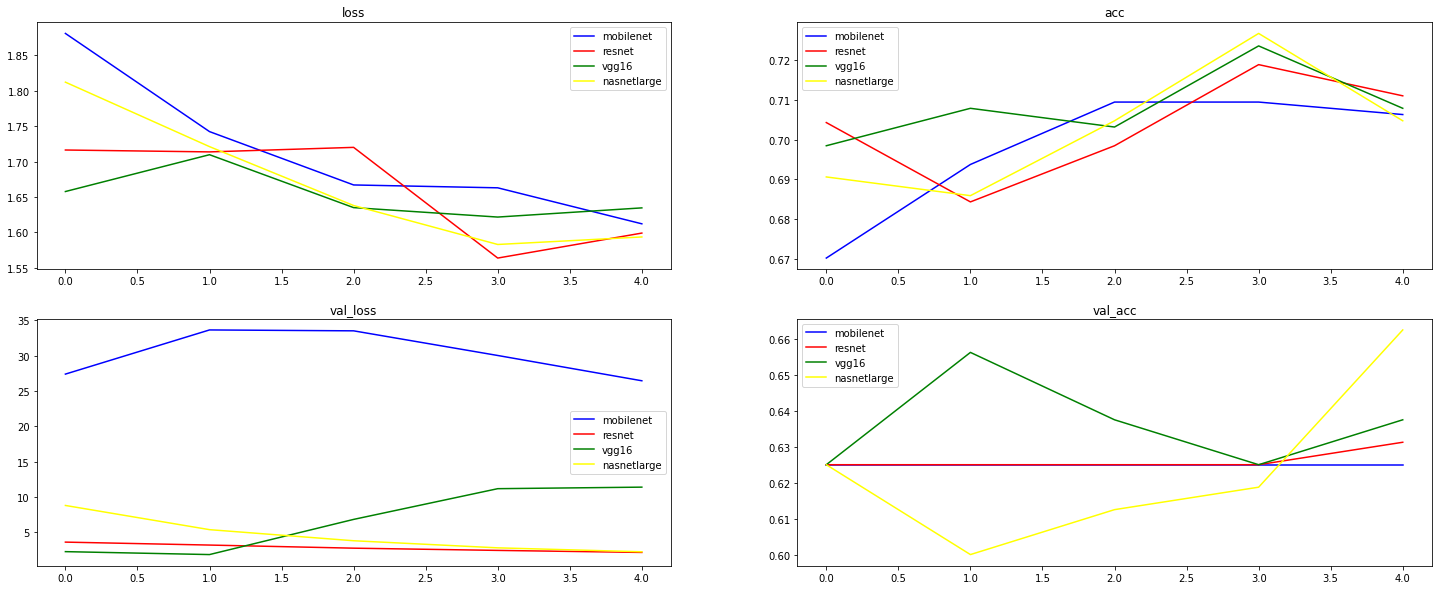

In [ ]:
plt.figure(figsize=(25, 10))
for i in range(0, 4):
  plt.subplot( 2, 2, i+1 )
  plt.plot( mobilenet_data.iloc[:,[i]] , 'b' , label='mobilenet' ) # 빠름 - 2분 17초
  plt.plot( resnet_data_acc.iloc[:,[i]] , 'r' , label='resnet' ) # 빠름 - 5분 40초
  plt.plot( nasnetlarge_data.iloc[:,[i]] , 'yellow' , label='nasnetlarge' ) # 약간 느림 - 15분 36초
  plt.plot( vgg16_data.iloc[:,[i]] , 'g' , label='vgg16' ) # 조금 느림 - 30분 23초
  plt.title( resnet_data_acc.columns[i] )
  plt.legend()
plt.show();

# CNN Model 2 - Brain Activate loc X , Y

# CNN Model Combine

In [ ]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

In [ ]:
# CV 활용 검토
def get_dataset():
 X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
 return X, y
 
def get_model(n_inputs, n_outputs):
 model = Sequential()
 model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
 model.add(Dense(n_outputs))
 model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = METRICS )
 return model
 
def evaluate_model(X, y):
 results = list()
 n_inputs, n_outputs = X.shape[1], y.shape[1]

 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

 for train_ix, test_ix in cv.split(X):
   X_train, X_test = X[train_ix], X[test_ix]
   y_train, y_test = y[train_ix], y[test_ix]

 model = get_model(n_inputs, n_outputs)
 model.fit(X_train, y_train, verbose=0, epochs=100)
  
 mae = model.evaluate(X_test, y_test, verbose=0)
 results.append(mae)
 return results
 
X, y = get_dataset()
results = evaluate_model(X, y)

# ML - Classification Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz, glob
from sklearn.metrics import accuracy_score

In [ ]:
dataset_dict = {
    'Alzheimer_split': {
        0: 'NonDemented', 
        1: 'VeryMildDemented', 
        2: 'MildDemented', 
        3: 'ModerateDemented', 
    },
    'activate_location': {
        0: 'Dis',
        1: 'activate'
    }
}
dataset_dict['activate_location'] = dict((g, i) for i, g in dataset_dict['activate_location'].items())
dataset_dict['Alzheimer_split'] = dict((r, i) for i, r in dataset_dict['Alzheimer_split'].items())

directory = '/content/drive/MyDrive/new'

def parse_dataset(dataset_path, ext='jpg'):
    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')
            return int(age), dataset_dict['activate_location'][int(gender)], dataset_dict['Alzheimer_split'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['ah_split', 'loc_x', 'loc_y', 'label']
    df = df.dropna()
    return df

df = parse_dataset(directory)
train , val = train_test_split( df[ df['label'] == 0].copy(), test_size=0.2 )

target =  'ah_split'

def X_y_split(df):
  X = df.drop(target, axis=1)
  y = df[target]
  return X, y

X_train, y_train = X_y_split(train)
X_val, y_val = X_y_split(val)

In [ ]:
base = y_train.mode()[0]
baseline = len(y_train) * [base]
baseline_acc = accuracy_score(y_train, baseline)
print(f'기준모델의 정확도는 {baseline_acc.round(3)} 입니다')

In [ ]:
tree_model = DecisionTreeClassifier(random_state=42, criterion="entropy", max_depth=10)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_val)

In [ ]:
dot_data = export_graphviz(tree_model,
                           max_depth=2,
                           feature_names=X_val.columns,
                           filled=True,
                           proportion=True)
display(graphviz.Source(dot_data))

graphviz.Source(dot_data).render('tree', format="png")